In [1]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
color_list = ['salmon', 'limegreen', 'mediumturquoise', 'cornflowerblue', 'fuchsia', 'khaki']

import copy as cp
import pickle
import pandas as pd
import sys
from ipywidgets import IntProgress
from IPython.display import display


import RandomPEPS as rpeps
import StructureMatrixGenerator as smg
import trivialSimpleUpdate as tsu
import DoubleEdgeFactorGraphs as defg
import SimpleUpdate as su
import bmpslib as bmps

# Comparing convergence time to fixed-point of trivial-Simple Update (tSU) and Belief Propagation (BP) over N different random PEPS experiments

In this experiment I calculated on **random PEPS** the ratio of **BP** iterations $T_{BP}$ to the **tSU** iterations $T_{SU}$ to convergance to a fixed-point. The convergence criteria for both algorithms was takes with respect to the two-body reduced density matrices (RDMs) as follows:

$
\begin{align}
\frac{1}{m}\sum_{\langle i,j\rangle} \|\rho_{ij}^{BP}-\rho_{ij}^{tSU}\|_1<dW
\end{align}
$

where $m$ coresponds to the number of edges in the tensor network and $dW$ is some pre-determined constant.

In [2]:
# tSU and BP parameters
N, M = 4, 4                                                   # NxM PEPS
bc = 'open'                                                   # boundary conditions
dw = 1e-6                                                     # maximal error allowed between two-body RDMS
d = 2                                                         # tensor network physical bond dimension
bond_dimensions = [2, 3, 4]                                   # maximal virtual bond dimensions allowed for truncation
t_max = 1000                                                  # maximal number of BP iterations
epsilon = 1e-10                                               # convergence criteria for BP messages (not used)
dumping = 0.                                                  # BP messages dumping between [0, 1]
iterations = 1000                                             # maximal number of tSU iterations
sched = 'parallel'                                            # tSU scheduling scheme 
num_experiments = 100                                         # number of random experiments for each bond dimension
smat, _ = smg.finitePEPSobcStructureMatrixGenerator(N, M)     # generating the PEPS structure matrix
n, m = smat.shape

In [3]:
ATD_D = []         # Averaged Trace Distance (ATD) for each virtual bond dimension D
BP_num_D = []      # numbeer of BP iterations
tSU_num_D = []     # numbeer of tSU iterations

## RUN

In [9]:
for D_max in bond_dimensions:
    ATD_tot = []
    BP_iters = []
    tSU_iters = []
    print('\n=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
    print('|               D = {}               |'.format(D_max))
    print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
    

    f = IntProgress(min=0, max=num_experiments, description='Runing:', bar_style='success') # instantiate the bar
    display(f) # display the bar
    for e in range(num_experiments):
        f.value += 1 # signal to increment the progress bar
        #if e % 10 == 0:
        #    dots = '*' * int(e // 10)
        #    spaces = '.' * int((num_experiments - e) // 10)
        #    print('[' + dots + spaces + ']')
        # draw some random PEPS Tensor Network
        tensors, weights = smg.randomTensornetGenerator(smat, d, D_max)
        BP_tensors, BP_weights = cp.deepcopy(tensors), cp.deepcopy(weights)

        # constructing the dual double-edge factor graph and run a single BP iteration
        graph = defg.defg()
        graph = su.TNtoDEFGtransform(graph, BP_tensors, BP_weights, smat)
        graph.sumProduct(1, epsilon, dumping, initializeMessages=1, printTime=0, RDMconvergence=0)
        BP_rdm = []
        for j in range(m):
                BP_rdm.append(tsu.BPdoubleSiteRDM1(j, BP_tensors, BP_weights, smat, cp.deepcopy(graph.messages_n2f)))

        # run BP and calculate two body rdms between two consecutive BP iterations
        for t in range(t_max):
            graph.sumProduct(1, epsilon, dumping, initializeMessages=1, printTime=0, RDMconvergence=0)

            ATD_BP = 0
            BP_rdm_next = []
            for j in range(m):
                BP_rdm_next.append(tsu.BPdoubleSiteRDM1(j,
                                                        BP_tensors,
                                                        BP_weights,
                                                        smat,
                                                        cp.deepcopy(graph.messages_n2f)))

                ATD_BP += tsu.traceDistance(BP_rdm_next[j], BP_rdm[j])
                BP_rdm[j] = BP_rdm_next[j]
            ATD_BP /= m
            #print('The ATD_BP is: {} at iteration {}'.format(ATD_BP, t))
            if ATD_BP < dw:
                #print('\n')
                #print('The final ATD_BP is: {} at iteration {}'.format(ATD_BP, t + 1))
                break
        BP_iters.append(t + 2)

        # calculate the double site rdm in tsu
        tSU_rdm = []
        for i in range(m):
            tSU_rdm.append(tsu.doubleSiteRDM(i, tensors, weights, smat))   


        # trivial SU run
        for i in range(iterations):
            tensors_next, weights_next = tsu.trivialsimpleUpdate(tensors,
                                                                 weights,
                                                                 smat,
                                                                 D_max, 
                                                                 scheduling='parallel')
            ATD = 0
            tSU_rdm_next = []
            for j in range(m):
                tSU_rdm_next.append(tsu.doubleSiteRDM(j, tensors_next, weights_next, smat))
                ATD += tsu.traceDistance(tSU_rdm_next[j], tSU_rdm[j])
                tSU_rdm[j] = tSU_rdm_next[j]
            ATD /= m
            if ATD < dw:
                #print('The ATD is: {} at iteration {}'.format(ATD, i))
                tensors = tensors_next
                weights = weights_next
                break
            tensors = tensors_next
            weights = weights_next  
        tSU_iters.append(i + 1)


        # calculate Averaged Trace Distance between the BP and tSU rdms.
        ATD_BP_tSU = 0
        for i in range(m):
            ATD_BP_tSU += tsu.traceDistance(BP_rdm[i], tSU_rdm[i])
        ATD_BP_tSU /= m
        #print('the total ATD between BP and tSU is {}'.format(ATD_BP_tSU))
        ATD_tot.append(ATD_BP_tSU)
    ATD_D.append(ATD_tot)
    BP_num_D.append(BP_iters)
    tSU_num_D.append(tSU_iters)  



=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
|               D = 2               |
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


IntProgress(value=0, bar_style='success', description='Runing:')


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
|               D = 3               |
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


IntProgress(value=0, bar_style='success', description='Runing:')


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
|               D = 4               |
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


IntProgress(value=0, bar_style='success', description='Runing:')

## PLOT RESULTS

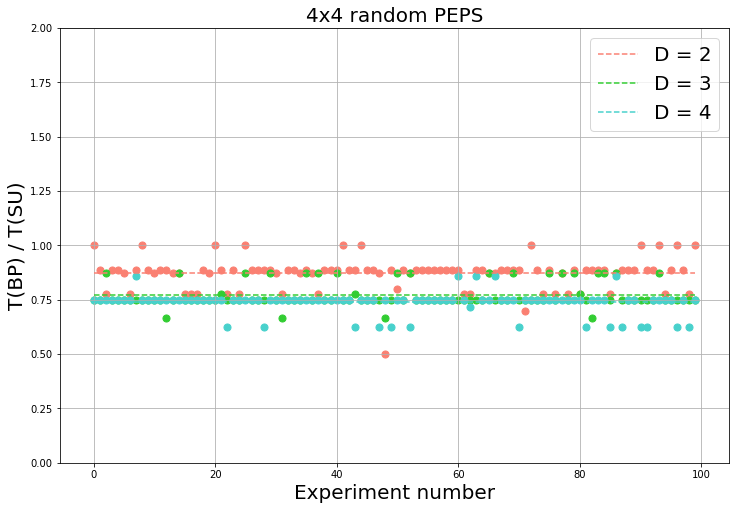

In [11]:
plt.figure(figsize=(12, 8))
fonts = 20
names = []
for i, D in enumerate(bond_dimensions):
 
    plt.scatter(range(num_experiments),
                np.asarray(BP_num_D[i]) / np.asarray(tSU_num_D[i]),
                color=mcd.CSS4_COLORS[color_list[i]], 
                s=50)
    
    plt.plot(range(num_experiments),
             np.mean(np.asarray(BP_num_D[i]) / np.asarray(tSU_num_D[i])) * np.ones((num_experiments, 1)),
             '--',
             color=mcd.CSS4_COLORS[color_list[i]])
    
    names.append('D = ' + str(D))
plt.title(str(N) + 'x' + str(M) + ' random PEPS', fontsize=fonts)
plt.xlabel('Experiment number', fontsize=fonts)
plt.ylabel('T(BP) / T(SU)', fontsize=fonts)
plt.legend(names, fontsize=fonts)
plt.ylim([0., 2.])
plt.grid()
plt.show()